# PyTorch hardware benchmark analysis

Single node throughput comparisons between different hardware options at NERSC.

In [1]:
import os
import re
import glob

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [11]:
ls /global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/

gpu-ngc_20.03_v0-nccl-n1/  gpu-v1.5.0-gloo-n2/   gpu-v1.5.0-nccl-n2/
gpu-v1.1.0-nccl-n1/        gpu-v1.5.0-gloo-n32/  gpu-v1.5.0-nccl-n32/
gpu-v1.2.0-nccl-n1/        gpu-v1.5.0-gloo-n4/   gpu-v1.5.0-nccl-n4/
gpu-v1.3.1-nccl-n1/        gpu-v1.5.0-gloo-n64/  gpu-v1.5.0-nccl-n64/
gpu-v1.4.0-nccl-n1/        gpu-v1.5.0-gloo-n8/   gpu-v1.5.0-nccl-n8/
gpu-v1.5.0-gloo-n1/        gpu-v1.5.0-nccl-n1/   hsw-v1.5.0-mpi-n1/
gpu-v1.5.0-gloo-n16/       gpu-v1.5.0-nccl-n16/  knl-v1.5.0-mpi-n1/


In [12]:
pattern = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/%s-%s-%s-n1/results.txt'

In [13]:
version = 'v1.5.0'

In [14]:
results_files = (
    glob.glob(pattern % ('hsw', version, 'mpi')) +
    glob.glob(pattern % ('knl', version, 'mpi')) + 
    glob.glob(pattern % ('gpu', version, 'nccl'))
)
results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-v1.5.0-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/knl-v1.5.0-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n1/results.txt']

In [15]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,backend,model
0,829.083929,2148.042172,1,hsw,v1.5.0,mpi,lstm
1,208.057813,717.366698,1,hsw,v1.5.0,mpi,alexnet
2,15.384836,56.229829,1,hsw,v1.5.0,mpi,resnet50
3,129.737128,282.426692,1,hsw,v1.5.0,mpi,cnn3d
4,242.310326,663.814937,1,knl,v1.5.0,mpi,lstm
5,180.397115,447.464069,1,knl,v1.5.0,mpi,alexnet
6,7.129029,44.966010,1,knl,v1.5.0,mpi,resnet50
7,43.457983,91.766203,1,knl,v1.5.0,mpi,cnn3d
8,8033.061209,16712.631644,1,gpu,v1.5.0,nccl,lstm
9,1734.232339,3030.756997,1,gpu,v1.5.0,nccl,alexnet


## Tables

In [16]:
# Training rate per hardware
results.groupby('model').apply(lambda g: pd.Series(data=g.train_rate.values, index=g.hardware))

hardware,hsw,knl,gpu
model,,,
alexnet,208.057813,180.397115,1734.232339
cnn3d,129.737128,43.457983,3420.986498
lstm,829.083929,242.310326,8033.061209
resnet50,15.384836,7.129029,326.592133


In [17]:
# Evaluation rate per hardware
results.groupby('model').apply(lambda g: pd.Series(data=g.inference_rate.values, index=g.hardware))

hardware,hsw,knl,gpu
model,,,
alexnet,717.366698,447.464069,3030.756997
cnn3d,282.426692,91.766203,9771.048662
lstm,2148.042172,663.814937,16712.631644
resnet50,56.229829,44.966010,972.024255


## Training throughput comparisons

In [18]:
#models = ['alexnet', 'vgg11', 'inceptionV3', 'resnet50', 'cnn3d', 'lstm']
models = ['alexnet', 'resnet50', 'cnn3d', 'lstm']
results_by_model = results.groupby('model')

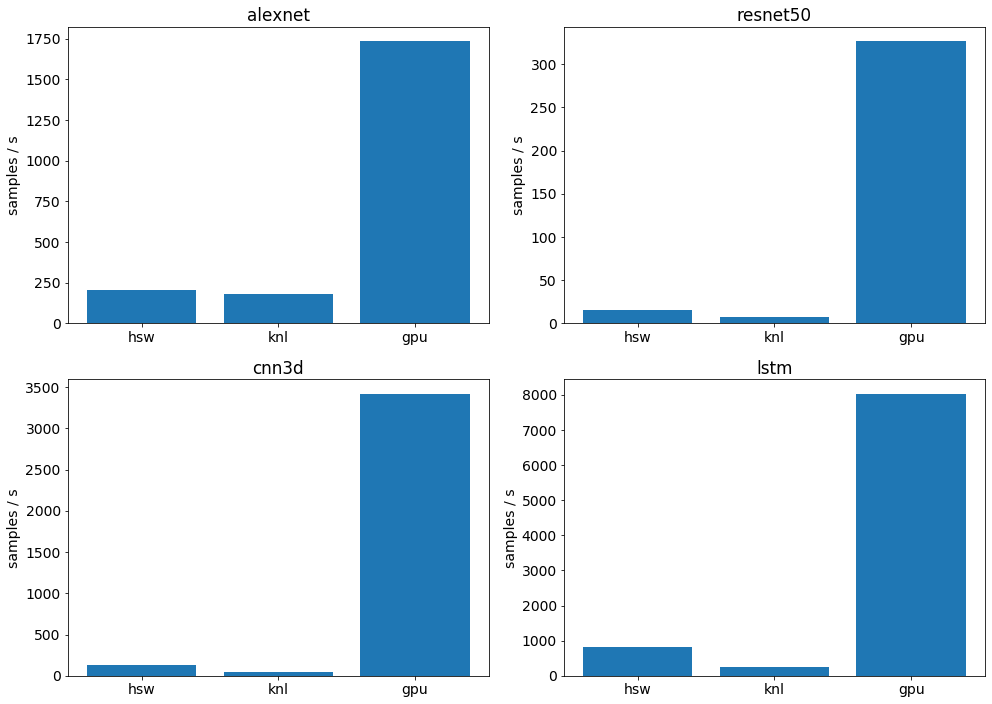

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for i, model in enumerate(models):
    ax = axs[i]
    model_results = results_by_model.get_group(model)
    ax.bar(model_results.hardware, model_results.train_rate, log=False)
    ax.set_title(model)
    ax.set_ylabel('samples / s')

plt.tight_layout()